## Grupo

227124 Jorge Henrique Monteiro dos Santos

262251 Vitor Mello de Araujo Lima

## Objetivo

Esta tarefa busca discutir os critérios de parada utilizados por diferentes algoritmos, que serão empregados para achar o mínimo da função de Himmelblau, exibida abaixo:

$$
f(x,y)=(x^2+y-11)^2+(x+y^2-7)^2
$$

A função de Himmelblau não é convexa, possui um máximo global e quatro mínimos locais de mesmo valor, sendo comumente utilizada para testar a performance de algoritmos de otimização.

Nas seções seguintes, serão analizados os algoritmos abaixo:


- Conjugado Gradiente
- Descida do Gradiente com Busca em Linha
- Nelder-Mead
- BFGS
- NEWOA ou BOBYQA


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

In [2]:
himm_func_call_cnt = 0
himm_grad_call_cnt = 0
himm_func_call_values = []

def himmelblau_func(x):
  global himm_func_call_cnt
  global himm_func_call_values
  himm_func_call_cnt += 1
  himm_func_call_values.append([x[0],x[1]])
  return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

def himmelblau_grad(x):
  global himm_grad_call_cnt
  himm_grad_call_cnt += 1
  dx = 2*(2*x[0]*(x[0]**2 + x[1] - 11) + x[0] + x[1]**2 - 7) 
  dy = 2*(x[0]**2 + 2*x[1]*(x[0] + x[1]**2 -7) + x[1] - 11)
  return np.array([dx, dy])

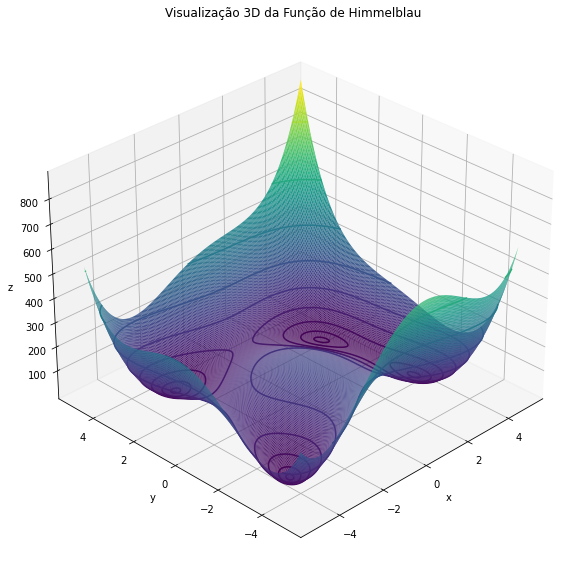

In [3]:
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection="3d") 
x_vals = np.linspace(-5, 5, 250)
y_vals = np.linspace(-5, 5, 250)
X, Y = np.meshgrid(x_vals, y_vals)
Z = himmelblau_func([X,Y])


plt.contour(X,Y,Z,np.arange(10)**3)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
plt.title('Visualização 3D da Função de Himmelblau')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(30, 225)

plt.show()

In [4]:
def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)
    
def visualize_opt(func, ps):
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    Z = func(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))    
    ps = np.array(ps)
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
    plt.plot(ps[:, 0], ps[:, 1], '-ro')
    plt.subplot(122)
    plt.semilogy(range(len(ps)), func(ps.T))
    pass

# Conjugado Gradiente

Para o Conjugado gradiente, foi usada a função _optimize_ do _scipy_. Foi passado o ponto $(4,4)$ como ponto de partida do algoritmo, e valores _default_ para tolerância.

Ponto mínimo          :  [3. 2.]
Valor da função       :  8.490750396096654e-21
Chamadas de função    :  17
Chamadas de gradiente :  17
Tempo de execução     :  2.14 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)




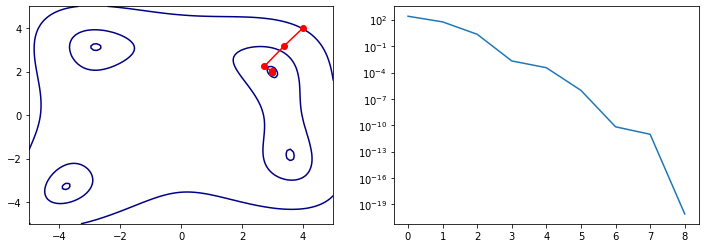

In [5]:
ps = [[4, 4]]

opt_res = opt.minimize(himmelblau_func, [4, 4], method="CG", jac=himmelblau_grad, callback=reporter) 

print("Ponto mínimo          : ", opt_res.x)
print("Valor da função       : ", opt_res.fun)
print("Chamadas de função    : ", opt_res.nfev)
print("Chamadas de gradiente : ", opt_res.njev)
## timeit module calls the function several times, so we use it after computing nfev, njev
exec_time = %timeit -o -q opt.minimize(himmelblau_func, [4, 4], method="CG", jac=himmelblau_grad)
print("Tempo de execução     : ", exec_time)
print("\n")
visualize_opt(himmelblau_func,ps)

# Descida do Gradiente com Busca em Linha

Para este algoritmo, foi utilizado a função _line-search_ do _scipy_. A função é usada pra encontrar o passo a ser utilizado. O procedimento realizado para encontrar o mínimo foi calcular o gradiente e fazer a busca em linha repetidas vezes até que se estivesse "andando" menos de $1e-5$ na função.

In [6]:
def descida_grad(func,func_grad,tol,init,maxpassos, callback = lambda x: x):
    
    f_old = func(init)   
    dx = func_grad(init)

    res = opt.line_search(func, func_grad,init,-dx)
    
    x_next =  init - res[0]*dx    
    f_new = func(x_next)
    
    l0_gd = [init[0],x_next[0]]
    l1_gd = [init[1],x_next[1]]
    f_values = [f_old,f_new]
    
    step = 1
    while (step < maxpassos) and (abs(f_new - f_old) >= tol):
        dx = func_grad(x_next)
        res = opt.line_search(func, func_grad,x_next, -dx)
        
        x_next =  x_next - res[0]*dx 
        
        f_old = f_new
        f_new = func(x_next)

        step = step + 1
        
        l0_gd.append(x_next[0])
        l1_gd.append(x_next[1])
        f_values.append(f_new) 
        
        callback(x_next)

    return l0_gd,l1_gd,f_values

Ponto mínimo          : (-3.7792348289132174,-3.2831080883679027)
Valor da função       :  4.3244826049285864e-07
Chamadas de função    :  88
Chamadas de gradiente :  33
Tempo de execução     :  4.98 ms ± 550 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)




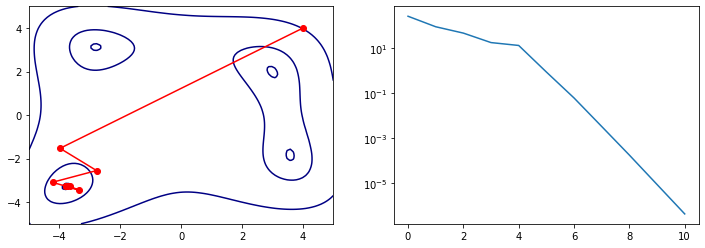

In [7]:
ps = [[4, 4]]

tol = 1.0e-5
himm_func_call_cnt = 0
himm_grad_call_cnt = 0

gd_x1_lr3,gd_x2_lr3, gd_func_lr3 = descida_grad(himmelblau_func,himmelblau_grad,tol,np.array([4.0,4.0]),5000,callback=reporter )

print("Ponto mínimo          : ({},{})".format(gd_x1_lr3[-1], gd_x2_lr3[-1]))
print("Valor da função       : ", gd_func_lr3[-1])
print("Chamadas de função    : ", himm_func_call_cnt)
print("Chamadas de gradiente : ", himm_grad_call_cnt)
exec_time = %timeit -o -q gd_x1_lr3,gd_x2_lr3, gd_func_lr3 = descida_grad(himmelblau_func,himmelblau_grad,tol,np.array([4.0,4.0]),5000)
print("Tempo de execução     : ", exec_time)
print("\n")
visualize_opt(himmelblau_func,ps)

# Nelder-Mead

Para o cálculo do mínimo foi utilizado o método _minimize_ do _scipy_, usando como triângulo inicial áquele dado pelas coordenadas $(-4,-4)$,$-4,1)$ e $(4,-1)$

Ponto mínimo       :  [ 3.58441449 -1.84811588]
Valor da função    :  1.0686566996168641e-08
Chamadas de função :  77
Tempo de execução  :  3.22 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)




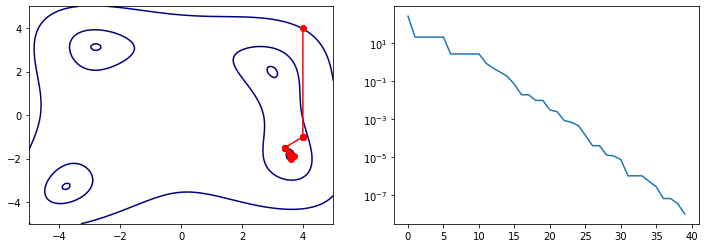

In [8]:
ini_simplex = np.array([[-4.0,-4.0],[-4.0,1.0],[4.0,-1.0]])
ps = [[4, 4]]

opt_res = opt.minimize(himmelblau_func, [0,0] ,method="Nelder-Mead",callback=reporter, options={'initial_simplex': ini_simplex}) 

print("Ponto mínimo       : ", opt_res.x)
print("Valor da função    : ", opt_res.fun)
print("Chamadas de função : ", opt_res.nfev)
exec_time = %timeit -o -q opt.minimize(himmelblau_func, [0,0] ,method="Nelder-Mead", options={'initial_simplex': ini_simplex}) 
print("Tempo de execução  : ", exec_time)
print("\n")
visualize_opt(himmelblau_func,ps)

# BFGS

Para este algoritmo, foram realizadas duas etapas. A primeira passando a função de cálculo do valor do gradiente implementada nesta tarefa, e a segunda sem função de cálculo de gradiente. Ambas etapas usaram o ponto $(4,4)$ como ponto de partida.

## Passando gradiente

Ponto mínimo          :  [2.99999986 2.00000019]
Valor da função       :  8.287611044190847e-13
Chamadas de função    :  10
Chamadas de gradiente :  10
Tempo de execução     :  951 µs ± 201 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)




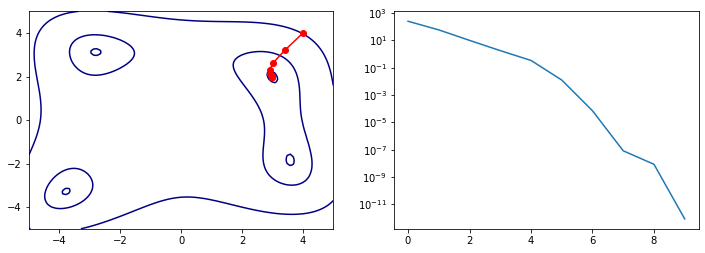

In [9]:
himm_grad_call_cnt = 0
ps = [[4, 4]]

opt_res = opt.minimize(himmelblau_func, [4,4] ,method="L-BFGS-B",jac=himmelblau_grad,callback=reporter) 

print("Ponto mínimo          : ", opt_res.x)
print("Valor da função       : ", opt_res.fun)
print("Chamadas de função    : ", opt_res.nfev)
print("Chamadas de gradiente : ", himm_grad_call_cnt)
exec_time = %timeit -o -q opt.minimize(himmelblau_func, [4,4] ,method="L-BFGS-B",jac=himmelblau_grad) 
print("Tempo de execução     : ", exec_time)
print("\n")
visualize_opt(himmelblau_func,ps)

## Sem gradiente

Ponto mínimo          :  [2.99999985 2.00000019]
Valor da função       :  8.50224355154359e-13
Chamadas de função    :  30
Chamadas de gradiente :  0
Tempo de execução     :  3.46 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)




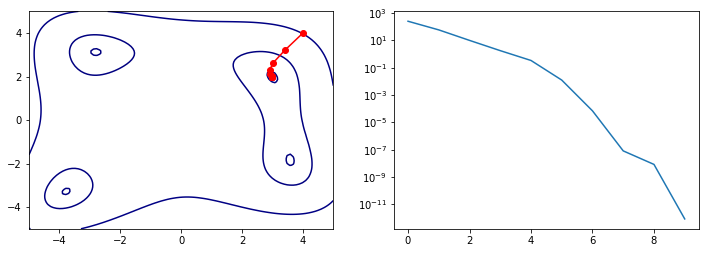

In [10]:
himm_grad_call_cnt = 0
ps = [[4, 4]]

opt_res = opt.minimize(himmelblau_func, [4,4] ,method="L-BFGS-B",callback=reporter) 

print("Ponto mínimo          : ", opt_res.x)
print("Valor da função       : ", opt_res.fun)
print("Chamadas de função    : ", opt_res.nfev)
print("Chamadas de gradiente : ", himm_grad_call_cnt)
exec_time = %timeit -o -q opt_res = opt.minimize(himmelblau_func, [4,4] ,method="L-BFGS-B") 
print("Tempo de execução     : ", exec_time)
print("\n")
visualize_opt(himmelblau_func,ps)

# NEWOA ou BOBYQA

Nesta etapa foi utilizado o algoritmo BOBYQA para encontrar o mínimo. Para isto, usou-se o pacote _Py-BOBYQA_, que provê a implementação do algoritmo.

In [11]:
%%capture 
!pip install Py-BOBYQA



In [12]:
import pybobyqa
himm_func_call_cnt=0
himm_func_call_values=[]

soln = pybobyqa.solve(himmelblau_func, [4,4])

# It is important to pass a local variable instead of a global one, 
# Since the function does 'ps=numpy(ps)'
himm_func_call_values_copy=himm_func_call_values.copy()

if soln.flag == soln.EXIT_SUCCESS :
    print("Ponto mínimo       : ", soln.x)
    print("Valor da função    : ", soln.f)
    print("Chamadas de função : ", soln.nf)
    exec_time = %timeit -o -q pybobyqa.solve(himmelblau_func, [4,4])
    print("Tempo de execução  : ", exec_time)
    print("\n")
    #visualize_opt(himmelblau_func,himm_func_call_values_copy)
else :
    print("Failed test")


Ponto mínimo       :  [3. 2.]
Valor da função    :  1.287703554675167e-21
Chamadas de função :  58
Tempo de execução  :  228 ms ± 122 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)




# Discussão de Resultados

A tabela abaixo compila os dados relativos ao número de chamadas à função objetivo, chamadas à função de cálculo de gradiente e tempo de execução para cada algoritmo:

| Algoritmo | Nº de $f$ | Nº de $\nabla$ | Tempo (ms) | Valor final de $f$
| :- | :-: | :-: | :-: | :-: |
| Conjugado Gradiente | 17 | 17 | 1,39 | $8,4\times10^{-21}$ |
| GD com Busca em Linha | 88 | 33 | 3,7 | $4,3\times10^{-7}$ |
| Nelder-Mead | 77 | - | 2,11 | $1,06\times10^{-8}$ |
| BFGS com gradiente | 10 | 10 | 0,526 | $8,3\times10^{-13}$ |
| BFGS sem gradiente | 30 | - | 1,79 | $8,5\times10^{-13}$ |
| BOBYQA | 58 | - | 109 | $1,3\times10^{-21}$ |



O **BOBYQA** apresentou um custo computacional mais elevado devido a necessidade de fazer um fit de uma função quadrática e achar o mínimo dessa função em cada iteração. Percebe-se que o custo computacional da função objetivo foi marginal em relação ao custo total. Dado que o custo de computacional desse algoritmo foi duas ordens de grandeza superior dos demais. Mesmo havendo algoritmos no grupo analisado com maiores números de chamada da função objetivo.

O **Nelder-Mead** é um outro algoritmo que não utiliza o gradiente da função objetivo. Entretanto, ele apresenta um número elevado de execuções da função objetivo. Essa característica pode ser um fator limitante para a sua aplicação quando a função objetivo possui um alto custo computacional. O algoritmo apresentou uma performance mediana no problema estudado, que não ressalta os pontos fortes do Nelder-Mead: robustez a ruido e não precisar do gradiente.  

O **Busca em Linha** apresentou o maior número de execuções da função objetivo e do gradiente. Entretanto, obteve resultados medianos. O número elevado de execuções pode ser explicado pela determinação do alpha/learning rate a cada iteração, que implica em resolver um problema de otimização de uma função univariavel. 

As duas variantes do **BFGS** alcançaram o mesmo ponto mínimo. Porém apresentaram variação significativa em termos de tempo de execução. Isso indica um custo computacional relevante para se estimar o valor do gradiente.

O **Conjugado Gradiente** alcançou um valor consideravelmente menor $(e-8)$ da função objetivo entre os algoritmos com tempo de execução semelhante. Portanto, ele apresentou a melhor razão entre precisão e tempo de execução.
